In [0]:
from google.colab import drive
drive.mount('/content/drive')
!mkdir data
!cp -r /content/drive/My\ Drive/Digital_Reputation_Challenge /content/data/
!git clone --recursive https://github.com/Microsoft/LightGBM
%cd LightGBM
!mkdir build
%cd build
!cmake ../../LightGBM
!make -j4
!git clone --recursive https://github.com/Microsoft/LightGBM.git
%cd LightGBM/python-package
!python3 setup.py install --gpu
!pip install eli5
!pip install catboost
!pip install category_encoders
!pip install bayesian-optimization

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.feature_selection import SelectFromModel
from  sklearn.decomposition import PCA
from eli5.sklearn import PermutationImportance
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings("ignore")

os.chdir('/content/data/Digital_Reputation_Challenge')
SEED = 17

params_XGboost = {'0': {'alpha': 0,
  'colsample_bytree': 0.6,
  'eta': 0.05,
  'learning_rate': 0.017,
  'max_delta_step': 5,
  'max_depth': 2,
  'min_child_samples': 100,
  'min_child_weight': 5,
  'n_estimators': 200,
  'num_leaves': 44,
  'scale_pos_weight': 1,
  'seed ': SEED},
 '1': {'alpha': 1,
  'colsample_bytree': 0.75,
  'eta': 0.225,
  'learning_rate': 0.033,
  'max_delta_step': 9,
  'max_depth': 1,
  'min_child_samples': 100,
  'min_child_weight': 2,
  'n_estimators': 200,
  'num_leaves': 19,
  'scale_pos_weight': 0.75,
  'seed ': SEED},
 '2': {'alpha': 0,
  'colsample_bytree': 0.75,
  'eta': 0.21,
  'learning_rate': 0.019,
  'max_delta_step': 3,
  'max_depth': 3,
  'min_child_samples': 150,
  'min_child_weight': 4,
  'n_estimators': 675,
  'num_leaves': 10,
  'scale_pos_weight': 0.75,
  'seed ': SEED},
 '3': {'alpha': 1,
  'colsample_bytree': 0.9,
  'eta': 0.39,
  'learning_rate': 0.021,
  'max_delta_step': 5,
  'max_depth': 1,
  'min_child_samples': 150,
  'min_child_weight': 7,
  'n_estimators': 325,
  'num_leaves': 20,
  'scale_pos_weight': 0.75,
  'seed ': SEED},
 '4': {'alpha': 1,
  'colsample_bytree': 0.7,
  'eta': 0.08,
  'learning_rate': 0.03,
  'max_delta_step': 9,
  'max_depth': 1,
  'min_child_samples': 50,
  'min_child_weight': 10,
  'n_estimators': 125,
  'num_leaves': 20,
  'scale_pos_weight': 0.75,
  'seed ': SEED }}

paramsCatBoost = {
'0': {'loss_function':'Logloss',
      'verbose': False,                        
      'random_seed': SEED,
      'thread_count': 1,
      'iterations': 130,
      'depth': 2,
      'border_count': 128     
     },    
'1': {'loss_function':'Logloss',
      'verbose': False,                        
      'random_seed': SEED,
      'thread_count': 1,
      'iterations': 90,
      'depth': 2,
      'border_count': 128     
     },
'2': {'loss_function':'Logloss',
      'verbose': False,                        
      'random_seed': SEED,
      'thread_count': 1,
      'iterations': 100,
      'depth': 2,
      'border_count': 128     
     },
'3': {'loss_function':'Logloss',
      'verbose': False,                        
      'random_seed': SEED,
      'thread_count': 1,
      'iterations': 90,
      'depth': 2 ,
      'border_count': 254    
     },          
'4': {'loss_function':'Logloss',
      'verbose': False,                        
      'random_seed': SEED,
      'thread_count': 1,
      'iterations': 70,
      'depth': 1,
      'border_count': 128     
     }}

In [0]:
#read data
X1_train = pd.read_csv('X1.csv')
X2_train = pd.read_csv('X2.csv')
X3_train = pd.read_csv('X3.csv')
X1_test = pd.read_csv('X1_test.csv')
X2_test = pd.read_csv('X2_test.csv')
X3_test = pd.read_csv('X3_test.csv')
target = pd.read_csv('Y.csv')
target = target.iloc[:, 1:]

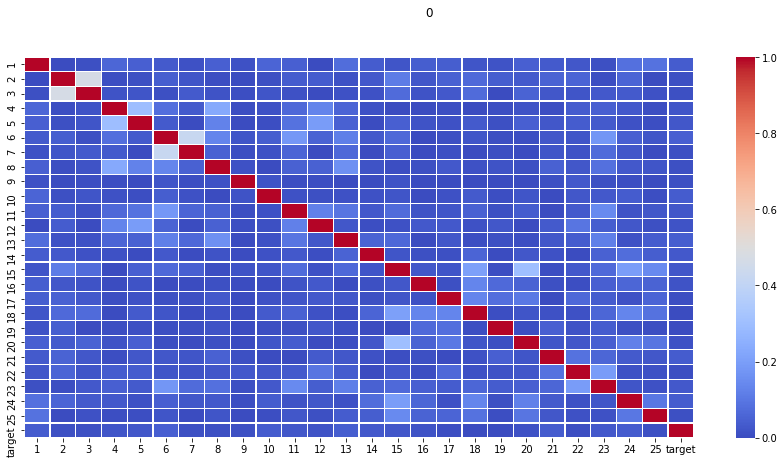

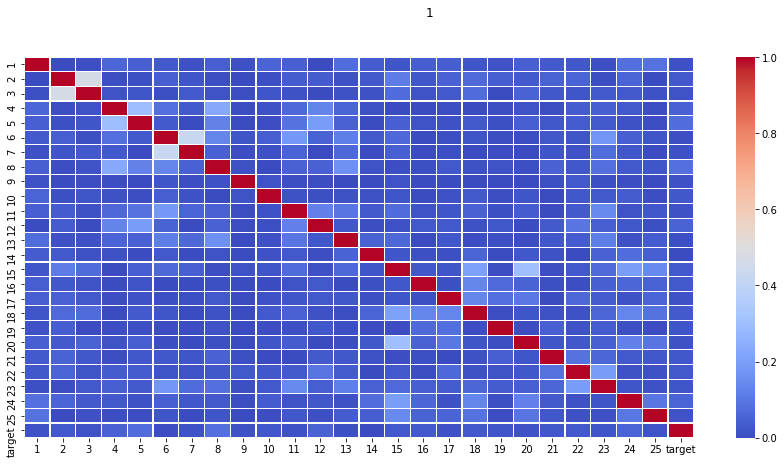

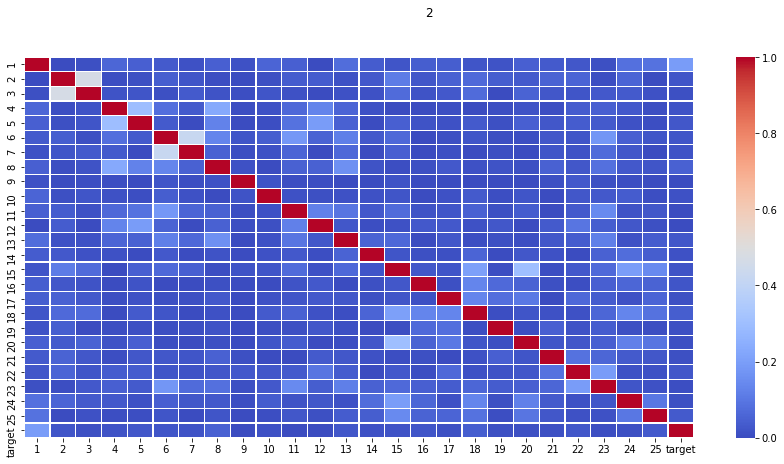

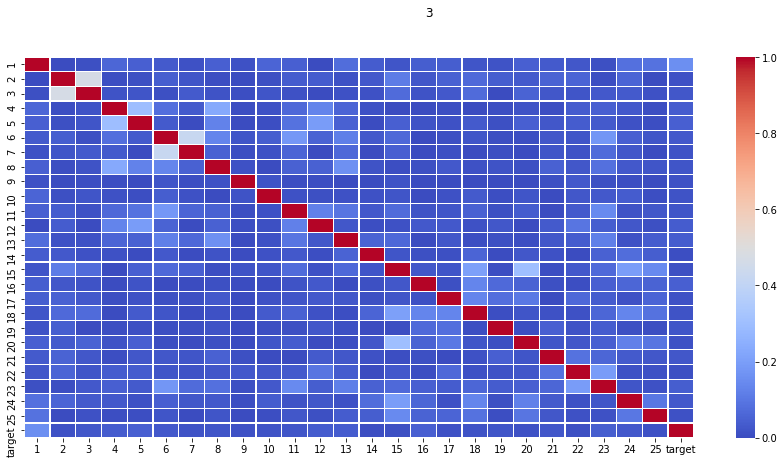

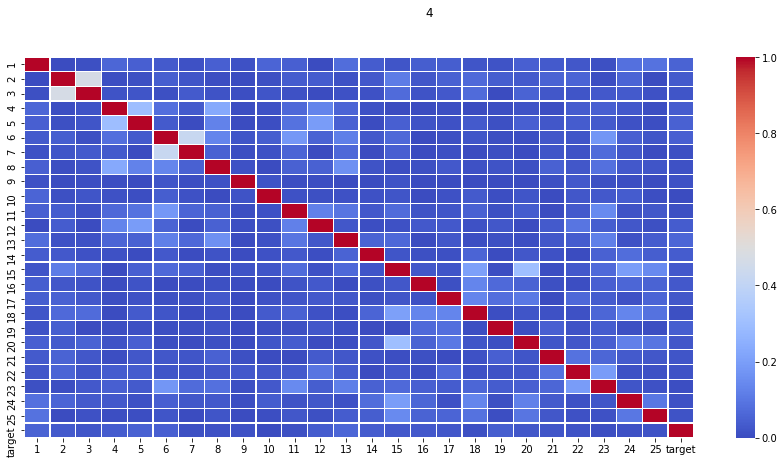

In [24]:
#plot corr matrix
for i in range(5):
    plt.figure(figsize=(15, 7))
    X1_train['target'] = target.iloc[: , i]
    sns.heatmap(np.abs(X1_train.drop('id', axis=1).corr()),
             linewidths=0.1, vmax=1.0, cmap='coolwarm')
    plt.suptitle(i)
    plt.show()


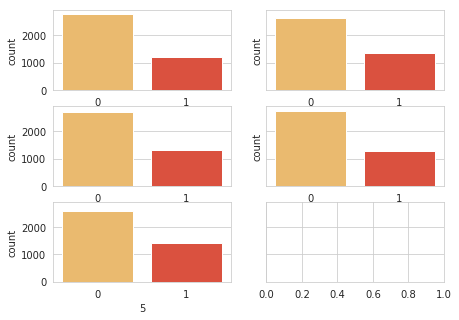

In [24]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(7, 5), sharey=True)
for i in range(5):
    sns.countplot(target.iloc[:, i], ax=axes[int(i / 2), i % 2],
                  palette='YlOrRd')

In [0]:
grouped_train = X2_train.groupby(['id'])['A'].agg('mean').reset_index()
grouped_test = X2_test.groupby(['id'])['A'].agg('mean').reset_index()

#use PCA for dimensionality reduction 
n_components = 2
scaler = StandardScaler(with_std=False)
pca = PCA(n_components=n_components, random_state=SEED)
full_data = X3_train.append(X3_test, sort=False).reset_index(drop=True)
transformed_data = pca.fit_transform(scaler.fit_transform(full_data))
X3_train_transformed = pd.DataFrame()
X3_test_transformed = pd.DataFrame()
X3_train_transformed['id'] = X3_train.id
X3_test_transformed['id'] = X3_test.id
for i in range(n_components):
    X3_train_transformed['pca' + str(i)] = transformed_data[:len(X3_train), i]
    X3_test_transformed['pca' + str(i)] = transformed_data[len(X3_train):, i]
del full_data


full_data = X2_train.append(X2_test, sort=False).reset_index(drop=True)
X2_train_transformed = pd.DataFrame()
X2_test_transformed = pd.DataFrame()
X2_train_transformed['id'] = X2_train.id.unique().tolist()
X2_test_transformed['id'] = X2_test.id.unique().tolist()

transformed_data = transform_data(full_data, n_components=n_components)
for i in range(n_components):
    X2_train_transformed['pca' + str(i)] = transformed_data[:len(X3_train), i]
    X2_test_transformed['pca' + str(i)] =  transformed_data[len(X3_train):, i]
del full_data

#merge dataframes
X_train = X1_train.merge(grouped_train, on='id', 
                how='inner').merge(X3_train_transformed,
                on='id', how='left').merge(
                X2_train_transformed, on='id', how='left')

X_test = X1_test.merge(grouped_test, on='id', 
                   how='inner').merge(X3_test_transformed,
                   on='id', how='left').merge(X2_test_transformed, 
                                              on='id', how='left')
del X1_train, X2_train, X3_train, X1_test, X2_test, X3_test

#drop useless columns
ID = X_test.id
for data in [X_train, X_test]:    
    data.drop('id', inplace=True, axis=1)
for col in X_train.columns:
    if X_train[col].nunique() == 1:
        X_train.drop(col, axis=1, inplace=True)     
        X_test.drop(col, axis=1, inplace=True)


#train models
models = {
    'xgboost': {'threshold': 0.0005, 'filename': 'predictions1.csv' },
    'catboost': {'threshold': 0.004, 'filename': 'predictions2.csv'}
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
for key, value in models.items():
  cv_scores = []
  predictions = []
  for i in range(5):     
      if key == 'xgboost':
          model = XGBClassifier(**params_XGboost[str(i)])
      elif key == 'catboost':     
          model = CatBoostClassifier(**paramsCatBoost[str(i)])       

      y = target.iloc[:, i]              
      train_X, val_X, train_y, val_y = \
                   train_test_split(X_train, y, random_state=SEED, 
                                    shuffle=True)
      model.fit(train_X.values, train_y.values)
      perm = PermutationImportance(model, cv=5, 
                                    scoring='roc_auc', 
                                   random_state=SEED)
      perm.fit(val_X.values, val_y.values)
      sel = SelectFromModel(perm, threshold=value['threshold'], 
                            prefit=True)
      X_train_transformed = sel.transform(X_train)
      X_test_transformed = sel.transform(X_test)        
      
      prediction, cv_scores_mean = train_and_predict(model,
                        X_train_transformed, y.values,
                        X_test_transformed, cv)   
      
      cv_scores.append(cv_scores_mean)
      predictions.append(prediction)

  print(round(np.array(cv_scores).mean(), 5))  
  write_to_submission_file(predictions, ID, value['filename'])  



In [0]:
simple blending
predictions1 = pd.read_csv('predictions1.csv')
predictions2 = pd.read_csv('predictions2.csv')
predictions = pd.DataFrame(predictions1.iloc[:, 1:].
                           add(predictions2.iloc[:, 1:]) * 0.5,
                           columns=['1', '2', '3', '4', '5'])
predictions['id'] = predictions1.id
predictions[['id', '1', '2', '3', '4', '5']].to_csv('predictions.csv', 
                                                    index=False)


In [0]:
def transform_data(data, n_components):
    rows, row_pos = np.unique(data.iloc[:, 0], return_inverse=True)
    cols, col_pos = np.unique(data.iloc[:, 1], return_inverse=True)
    sparse_matrix = np.zeros((len(rows), len(cols)))
    sparse_matrix[row_pos, col_pos] = 1    
    scaler = StandardScaler(with_std=False)
    pca = PCA(n_components=n_components, random_state=SEED)
    cols_ = sparse_matrix.sum(axis=0)
    rows_ = sparse_matrix.sum(axis=1)
    minimum_users_per_group = 5
    selected_cols = cols_ >= minimum_users_per_group
    trimmed_sparse_matrix = sparse_matrix[:, selected_cols]
    transformed_data = pca.fit_transform(scaler.fit_transform(
        trimmed_sparse_matrix))
    return transformed_data

def train_and_predict(model, X_train, y_train, 
                            X_test, cv, scoring='roc_auc'):        
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, 
                                scoring=scoring)   
    print('CV mean: {}'.format(round(cv_scores.mean(), 5)))
    model.fit(X_train, y_train)    
    return model.predict_proba(X_test)[:, 1], cv_scores.mean()    

def write_to_submission_file(probas, ID, filename): 
    tmp = pd.DataFrame(probas).T
    baseline = pd.DataFrame(tmp.values, 
                            columns=['1', '2', '3', '4', '5'])
    baseline['id'] = ID
    baseline[['id', '1', '2', '3', '4', '5']].to_csv(filename, 
                                                     index=False)
    

In [0]:
#grouped_train = X2_train.groupby(['id'])['A'].agg('mean').reset_index()
#grouped_test = X2_test.groupby(['id'])['A'].agg('mean').reset_index()
#print(grouped_train.head())

#grouped_train['target'] = target.iloc[:, 1]
#print(grouped_train[grouped_train.target == 1]['A'].mean())
#print(grouped_train[grouped_train.target == 0]['A'].mean())
#grouped_train.groupby('target')['A'].mean().plot(kind='bar', rot=90)
# sns.set(style="whitegrid")
# sns.barplot(data = grouped_train,
#            x='target', y='A', palette="YlOrRd")
#grouped_train.groupby('target')['A'].agg(['mean']).reset_index()

#grouped_train.groupby('target', as_index=False)['A'].agg(['mean'])
# def make_mean_encoding_simple(train, test, target_col_name, feature_col_names):
#     train_copy = train.copy()
#     test_copy = test.copy()

#     for col in feature_col_names:
#         col_name = col + '_target_mean'
#         grouped = train_copy.groupby(col)[target_col_name].agg(
#             ['mean']).rename({'mean': col_name}, axis=1)  
#         train_copy = train_copy.merge(grouped, on=col, how='left')
#         test_copy = test_copy.merge(grouped, on=col, how='left')       
#         test_copy[col_name].fillna(0, inplace=True)
    
    
#     return train_copy, test_copy   


# def make_mean_encoding(df_tr, target_col_name, feature_col_name):
#     y_tr = df_tr[target_col_name].values
#     skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=123)
#     train_new = df_tr.copy()
 
#     global_mean = df_tr[target_col_name].mean()
    
#     train_new[feature_col_name + '_mean_target'] = global_mean  
#     for tr_ind, val_ind in skf.split(y_tr, y_tr):
#         X_tr, X_val = df_tr.iloc[tr_ind].copy(), df_tr.iloc[val_ind].copy()
#         for col in [feature_col_name]:
#             means = X_val[col].map(X_tr.groupby(col)[target_col_name].mean())
#             X_val[col + '_mean_target'] = means
#         train_new.iloc[val_ind] = X_val 
    
#     train_new.fillna(global_mean, inplace=True)
 
#     return train_new



# model = LogisticRegression()
# params = {
#             'C': [2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8],
#             'penalty': ['l2', 'l1']
#          }
# clf = GridSearchCV(model, param_grid=params, 
#                          cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
# y = target.iloc[:, 0]  
# clf.fit(X_train, y)
# print(clf.best_params_)  
# print(clf.best_score_) 


# param_model = { 
#   'metric': 'auc',
#   'num_threads': 1,
#   'random_state': SEED,
#   'learning_rate': 0.013987131026472387    
#   'num_leaves': 26,    
#   'n_estimators': 90
# }
# model = lgbm.LGBMClassifier(**param_model)
# params = {#'n_estimators': range(65, 120, 5),
#           #'num_leaves': range(25, 37, 1)          
#           'learning_rate': np.logspace(-3, 1, num=200) 
#          }
# clf = GridSearchCV(model, param_grid=params, 
#                          cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
# y = target.iloc[:, 0]  
# clf.fit(X_train, y)
# print(clf.best_params_)  
# print(clf.best_score_) 




#lgbm.LGBMClassifier

# model = CatBoostClassifier(loss_function='Logloss',
#                         verbose=False,                        
#                         random_seed=SEED,
#                         thread_count=4                        
#                        )   



#model = XGBClassifier(**model_param)

#params = { #'n_estimators': range(90, 200, 5),
           #'max_depth':  range(1, 9, 1),
           #'min_child_weight':range(1, 10, 1),
           #'colsample_bytree':[i / 10.0 for i in range(1, 10)]           
           #'reg_alpha':[1e-6, 1e-5, 1e-2, 0.1, 1, 100]
           #'learning_rate': np.logspace(-3, 1, num=200)         
           #'eta': [0.001, 0.02, 0.03, 0.04, 0.05, 0.07, 0.08, 0.09]
           #'alpha': [0, 0.5, 1]
#          }
# clf = GridSearchCV(model, param_grid=params, 
#                   cv=cv, scoring='roc_auc', 
#                   n_jobs=-1, verbose=1)
# clf.fit(X_train_transformed, target.iloc[:, 4])
# print(clf.best_params_)  
# print(clf.best_score_) 

#eli5.show_weights(perm, feature_names = val_X.columns.tolist(), top=100)
#X_train['target'] = target.iloc[:, 4]
#print(X_train.head(50))
#print(X_train.iloc[:, selector.get_support()]
# bin_col = ['col1'] + [f'col{i}' for i in range(10, 26)]


# (4000, 6)
# CV mean: 0.59427
# (4000, 6)
# CV mean: 0.59373
# (4000, 13)
# CV mean: 0.60713
# (4000, 4)
# CV mean: 0.58861
# (4000, 2)
# CV mean: 0.53476
# 0.5837

#threshold=0.004
# (4000, 9)
# CV mean: 0.59628
# (4000, 4)
# CV mean: 0.59713
# (4000, 2)
# CV mean: 0.60868
# (4000, 3)
# CV mean: 0.58713
# (4000, 5)
# CV mean: 0.54376
# 0.5866

#1 
#model_param = {
  #'alpha': 0,
  #'colsample_bytree': 0.6,
  #'eta': 0.05,
  #'learning_rate': 0.061509857885805014,
  #'max_delta_step': 5,
  #'max_depth': 1,
  #'min_child_samples': 100,
  #'min_child_weight': 5,
  #'n_estimators': 156,
  #'num_leaves': 44,
  #'scale_pos_weight': 1,
  #'seed ': SEED 

#2





# col_to_drop = { 1: ['col16','col17','col20','col18','col19', 'col3', 'col14', 'col11'],
#                 2: ['col25','col20','col12','col21','col14', 'col16', 'col17', 'col18', 'col19'],
#                 3: ['col14','col3','col21','col20','col19', 'col18', 'col17', 'col16'],
#                 4: ['col17', 'col2', 'col3','col7','col10','col11','col12','col14','col16','col15','col18','col19','col20','col21','col22','col23', 'col24'],
#                 5: ['col18','col10','col14','col16','col17', 'col3', 'col20', 'col21', 'col2'],
# } 

# col_for_predict1 = ['col6','col21','col26','col8', 'col28', 'col1', 'col27', 'col2', 'col5']         
# col_for_predict2 = ['col5','col8','col2','col27', 'col4', 'col22', 'col30', 'col29', 'col9']         
# col_for_predict3 = ['col1','col30','col6','col8', 'col29', 'col28']         
# col_for_predict4 = ['col1','col27','col8','col6', 'col25']  
# col_for_predict5 = ['col13']         

# d_col = {
#     1: col_for_predict1,
#     2: col_for_predict2,
#     3: col_for_predict3,
#     4: col_for_predict4,
#     5: col_for_predict5,

# }

#train_X, val_X, train_y, val_y = \
        #      train_test_split(X_train, target.iloc[:, i-1], random_state=SEED,
        #                      shuffle=True)
        #model.fit(train_X.values, train_y.values)
        #perm = PermutationImportance(model, cv=10, 
        #                              scoring='roc_auc', random_state=SEED)
        #perm.fit(val_X.values, val_y.values)
        #eli5.show_weights(perm, feature_names = val_X.columns.tolist())
        # sel = SelectFromModel(perm, threshold=0.001, prefit=True)
        # X_train_transformed = sel.transform(X_train)
        # X_test_transformed = sel.transform(X_test) 

# bin_col = ['col1', 'col2', 'col3'] + [f'col{i}' for i in range(10, 26)]
# full_data = X_train.append(X_test, sort=False).reset_index(drop=True)
# cat_features = bin_col
# count_encoding = ce.CountEncoder(cols = cat_features)
# count_encoded = count_encoding.fit_transform(full_data[cat_features])
# full_data = full_data.join(count_encoded.add_suffix('_count'))

# X_train = full_data.iloc[:len(X_train), :]
# X_test = full_data.iloc[len(X_train):, :]
# del full_data
# X_train_transformed = pd.DataFrame(X_train_transformed)
# col_names = [f'col{i}' for i in range(1, len(X_train_transformed.columns) + 1)]
# X_train_transformed.columns = col_names
# cat_features = [4, 5, 6, 7]
# model = CatBoostClassifier(loss_function='Logloss',
#                         verbose=False,                        
#                         random_seed=SEED,
#                         thread_count=4                        
#                        )   

# params = {'iterations': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140],
#           'depth': [2, 3, 4, 5, 6, 7],
#           'border_count': [128, 254]
#          }
# clf = GridSearchCV(model, param_grid=params, 
#                          cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)

# for i in [1, 2, 3, 4, 5]: 
#     print(i)
#     y = target.iloc[:, i-1]  
#     clf.fit(X_train_transformed.values, y)
#     print(clf.best_params_)  
#     print(clf.best_score_) 

#clf.best_estimator_.fit(train, y)

#  '5': {'alpha': 1,
#   'colsample_bytree': 0.7,
#   'eta': 0.08,
#   'learning_rate': 0.03,
#   'max_delta_step': 9,
#   'max_depth': 1,
#   'min_child_samples': 50,
#   'min_child_weight': 10,
#   'n_estimators': 125,
#   'num_leaves': 20,
#   'scale_pos_weight': 0.75,
#   'seed ': SEED }}

# space_xgb2 = {
#             'n_estimators': hp.choice('n_estimators', range(50, 200)),
#             'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
#             'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
#             'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
#             'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
#             'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
#             'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
#             'eval_metric': 'auc',
#             'objective': 'binary:logistic',
#             # Increase this number if you have more cores. Otherwise, remove it and it will default
#             # to the maxium number.
#             'nthread': 4,
#             'booster': 'gbtree',
#             'tree_method': 'exact',
#             'silent': 1
#         }
# best = fmin(fn=hyperopt_xgb_score, space=space_xgb2, 
#             algo=tpe.suggest, max_evals=10)
# print('best:')
# print(best)


# dtrain = xgb.DMatrix(X_train_transformed, label=target.iloc[:, 0])
# xgb_bo = BayesianOptimization(xgb_evaluate, {'max_depth': (2, 7), 
#                                              'gamma': (0, 1),
#                                              'colsample_bytree': (0.3, 0.9)})
# Use the expected improvement acquisition function to handle negative numbers
# Optimally needs quite a few more initiation points and number of iterations
#xgb_bo.maximize(init_points=3, n_iter=5, acq='ei')
#bin_col = ['col1'] + [f'col{i}' for i in range(10, 26)]
# bin_col = ['col1'] 
# full_data = X_train.append(X_test, sort=False).reset_index(drop=True)
# cat_features = bin_col
# count_encoding = ce.CountEncoder(cols = cat_features)
# count_encoded = count_encoding.fit_transform(full_data[cat_features])
# full_data = full_data.join(count_encoded.add_suffix('_count'))

# X_train = full_data.iloc[:len(X_train), :]
# X_test = full_data.iloc[len(X_train):, :]
# del full_data

# target_encoding = ce.TargetEncoder(cols=cat_features)
# target_encoding.fit(X_train[cat_features], target.iloc[:, 0])                    
# X_train = X_train.join(target_encoding.transform(X_train[cat_features])
#                     .add_suffix('_target'))                  

#for data in [X_train, X_test]:            
     #data['col4'] = np.log1p(data['col4'])
     #data['col5'] = np.log1p(data['col5'])
     #data['col6'] = np.log1p(data['col6'])
     #data['col26'] = np.log1p(data['col26'])
     #data.drop('col27', inplace=True, axis=1)
#     pass






#bin_col = ['col1'] + [f'col{i}' for i in range(10, 26)]
#for data in [X_train, X_test]:            
#    pass
    # data['bin_sum1'] = data[bin_col].sum(axis=1)
    # data['bin_sum2'] = (data[bin_col].sum(axis=1) == 0).astype('int')
    # data['bin_sum3'] = (data[bin_col].sum(axis=1) == 17).astype('int')
    #data['equal_2_3'] = (data.col2 == data.col3).astype(np.int8)
    #data['sum_2_3'] = data.col2 + data.col3
    #data['product_2_3'] = data.col2 * data.col3  

#     #  for col in col_for_target_mean:
#     #     del X_train[col + '_target_mean']
#     #     del X_test[col + '_target_mean']
#X_train['target'] = target.iloc[:, i-1]
     #X_train, X_test = make_mean_encoding_simple(X_train, X_test,
     #                                       'target', col_for_target_mean)
     #del X_train['target']
     #print(X_train.shape, X_test.shape) 

# space_xgb2 = {
#             'n_estimators': hp.choice('n_estimators', range(50, 200)),
#             'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
#             'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
#             'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
#             'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
#             'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
#             'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
#             'eval_metric': 'auc',
#             'objective': 'binary:logistic',
#             # Increase this number if you have more cores. Otherwise, remove it and it will default
#             # to the maxium number.
#             'nthread': 4,
#             'booster': 'gbtree',
#             'tree_method': 'exact',
#             'silent': 1
#         }

# best = fmin(fn=hyperopt_xgb_score, space=space_xgb2, 
#             algo=tpe.suggest, max_evals=10)
# print('best:')
# print(best)

# params_XGBoost = {
#   'alpha': 0,
#   'colsample_bytree': 0.6,
#   'eta': 0.05,
#   'learning_rate': 0.017,
#   'max_delta_step': 5,
#   'max_depth': 2,
#   'min_child_samples': 100,
#   'min_child_weight': 5,
#   'n_estimators': 300,
#   'num_leaves': 44,
#   'scale_pos_weight': 1,
#   'seed ': SEED}
# model = XGBClassifier(**params_XGBoost)                  
# model.fit(X_train, y_train, 
#              early_stopping_rounds=5, 
#              eval_set=[(X_valid, y_valid)],
#              verbose=False)
# clf = GridSearchCV(model, param_grid=params_XGBoost, 
#                   cv=cv, scoring='roc_auc', 
#                   n_jobs=1, verbose=0)
# clf.fit(X_train, target.iloc[:, i-1])
# print(clf.best_params_)  

# for i in [1, 2, 3, 4, 5]:      
#     print(i)
#     model = XGBClassifier()                  
#     clf = GridSearchCV(model, param_grid=params_for_grid, 
#                       cv=cv, scoring='roc_auc', 
#                       n_jobs=1, verbose=0)
#     clf.fit(X_train, target.iloc[:, i-1])
#     print(clf.best_params_)


# X2_all = X2_train.append(X2_test, sort=False).reset_index(drop=True)
# X2_all, svd = transform_x2(X2_all)

# X2_train = X2_all[X2_all.id.isin(X1_train.id)]
# X2_test = X2_all[X2_all.id.isin(X1_test.id)]
# del X2_all

#merge_data = X1_train.merge(X2_train, on='id', how='inner').merge(X3_train,
#                  on='id', how='left').merge(target,on='id', how='left')

# X_test = X1_test.merge(X2_test, on='id', how='inner').merge(X3_test,
#                   on='id', how='left')
#data['bin_sum'] = data[bin_col].sum(axis=1)
    #data['equal_2_3'] = (data.col2 == data.col3).astype(np.int8)
    #data['sum_2_3'] = data.col2 + data.col3
    #data['product_2_3'] = data.col2 * data.col3
    #print(X3_train_transformed[:10])
#X_train.shape, X_test.shape

# import warnings
# warnings.filterwarnings("ignore")
# feature_names = X3_train.columns.tolist()
# del feature_names[0]
# corr_list = []    
# for i in feature_names:
#     corr = np.corrcoef(X3_train[i], target.iloc[:, 5])[0, 1]
#     if corr > 0.7:
#         print('{}, {}'.format(i, corr))
    

#np.corrcoef(X3_train['1'], target.iloc[:, 5])[0, 1]
  # corr_list.append(corr)          
  # corr_feature = X.iloc[:, 
  #                   np.argsort(np.abs(corr_list))[-100:]].columns.tolist()    
  # corr_support = [True if i in 
  #                   corr_feature else False for i in feature_names]
#print(X3_train['1'].value_counts())
# grouped_train = X2_train.groupby(['id'])['A'].agg('count').reset_index()
# grouped_test = X2_test.groupby(['id'])['A'].agg('count').reset_index()
# print(grouped_train[:10])
#print(grouped[:100])
#sns.countplot(target.iloc[:, 3])
# X1_train['y1'] = target.iloc[:, 1]
# X1_train['y2'] = target.iloc[:, 2]
# X1_train['y3'] = target.iloc[:, 3]
# X1_train['y4'] = target.iloc[:, 4]
# X1_train['y5'] = target.iloc[:, 5]

#col = [str(i) for i in range(2, 26)]
#bin_col = ['col1'] + [f'col{i}' for i in range(10, 26)]
#print(X_train.head())
# plt.figure(figsize=(25, 10))
# sns.heatmap(X1_train[col].corr(),
#             cmap='coolwarm', annot=True)


#X1_train['9'].value_counts().head(25)
#target.head()
#print(X_train.head())
#f_names = X_train.columns.tolist()
#model = XGBClassifier(**params_XGboost['1'])
#train, val, y_train, y_val = train_test_split(X_train, target, random_state=SEED)
#model.fit(train.values, y_train.iloc[:, 0].values)
#perm = PermutationImportance(model, cv=5, scoring='roc_auc', random_state=SEED)
#perm.fit(val.values, y_val.iloc[:, 0].values)
# params = {'1': {'learning_rate': 0.06,
#   'objective': 'binary',
#   'metric': 'auc',
#   'num_threads': 1,
#   'num_leaves': 256,
#   'verbose': 1,
#   'random_state': SEED, 
#   'n_estimators': 50,
#   'device' : 'gpu',
#   'gpu_platform_id': 0,
#   'gpu_device_id':0
#   },         
#   '2': {'learning_rate': 0.1,
#   'objective': 'binary',
#   'metric': 'auc',
#   'num_threads': 1,
#   'num_leaves': 256,
#   'verbose': 1,
#   'random_state': SEED, 
#   'n_estimators': 120,
#   'device' : 'gpu',
#   'gpu_platform_id': 0,
#   'gpu_device_id':0
#   },       
#   '3': {'learning_rate': 0.02,
#   'objective': 'binary',
#   'metric': 'auc',
#   'num_threads': 1,
#   'num_leaves': 256,
#   'verbose': 1,
#   'random_state': SEED,
#   'n_estimators': 120,
#   'device' : 'gpu',
#   'gpu_platform_id': 0,
#   'gpu_device_id':0
#   },         
#   '4': {'learning_rate': 0.1,
#   'objective': 'binary',
#   'metric': 'auc',
#   'num_threads': 1,
#   'num_leaves': 256,
#   'verbose': 1,
#   'random_state': SEED, 
#   'n_estimators': 120,
#   'device' : 'gpu',
#   'gpu_platform_id': 0,
#   'gpu_device_id':0
#   },         
#   '5': {'learning_rate': 0.06,
#   'objective': 'binary',
#   'metric': 'auc',
#   'num_threads': 1,
#   'num_leaves': 256,
#   'verbose': 1,
#   'random_state': SEED,
#   'n_estimators': 150, 
#   'device' : 'gpu',
#   'gpu_platform_id': 0,
#   'gpu_device_id':0
#   }}
# X1_train = pd.read_csv('X1.csv')
# X2_train = pd.read_csv('X2.csv')
# X3_train = pd.read_csv('X3.csv')
# X1_test = pd.read_csv('X1_test.csv')
# X2_test = pd.read_csv('X2_test.csv')
# X3_test = pd.read_csv('X3_test.csv')
# target = pd.read_csv('Y.csv')
# grouped_train = X2_train.groupby(['id'])['A'].agg('count').reset_index()
# grouped_test = X2_test.groupby(['id'])['A'].agg('count').reset_index()

# n_components = 2
# full_data = X3_train.append(X3_test, sort=False).reset_index(drop=True)
# truncated_data = transform_x2(full_data, use_pca=True,
#                                      n_components=n_components)

# X3_train_transformed = pd.DataFrame(truncated_data[:len(X3_train)])
# X3_test_transformed = pd.DataFrame(truncated_data[len(X3_train):])
# X3_train_transformed['id'] = X3_train.id
# X3_test_transformed['id'] = X3_test.id
# for i in range(n_components):
#     X3_train_transformed['pca' + str(i)] = truncated_data[:len(X3_train), i]
#     X3_test_transformed['pca' + str(i)] = truncated_data[len(X3_train):, i]
# del full_data

# n_components = 2
# full_data = X2_train.append(X2_test, sort=False).reset_index(drop=True)
# truncated_data = transform_x2(full_data, use_pca=True,
#                               n_components=n_components, sparse=True)

# X2_train_transformed = pd.DataFrame(truncated_data[:len(X3_train)])
# X2_test_transformed = pd.DataFrame(truncated_data[len(X3_train):])
# X2_train_transformed['id'] = X2_train.id.unique().tolist()
# X2_test_transformed['id'] = X2_test.id.unique().tolist()

# for i in range(n_components):
#     X2_train_transformed['t_' + str(i)] = truncated_data[:len(X3_train), i]
#     X2_test_transformed['t_' + str(i)] = truncated_data[len(X3_train):, i]

# merge_data = X1_train.merge(grouped_train, on='id', 
#                 how='inner').merge(X3_train_transformed,
#                 on='id', how='left').merge(
#                 X2_train_transformed, on='id', how='left').merge(
#                 target,on='id', how='left')
# X_train = merge_data.iloc[:, :-5]
# target = merge_data.iloc[:, -5:]
# X_test = X1_test.merge(grouped_test, on='id', 
#                    how='inner').merge(X3_test_transformed,
#                    on='id', how='left').merge(X2_test_transformed, 
#                                               on='id', how='left')
# del merge_data, X1_train, X2_train, X3_train, X1_test, X2_test, X3_test    
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
# col_to_drop = ['id']
# ID = X_test.id
# for data in [X_train, X_test]:    
#     data.drop(col_to_drop, inplace=True, axis=1)
# col_names = [f'col{i}' for i in range(1, len(X_train.columns) + 1)]
# X_train.columns = col_names
# X_test.columns = col_names
# for col in X_train.columns:
#     if X_train[col].nunique() == 1:
#         X_train.drop(col, axis=1, inplace=True)     
#         X_test.drop(col, axis=1, inplace=True)

# cv_scores = []
# predictions = []
# for i in [1, 2, 3, 4, 5]:          
#      if isXGBoost:           
#         model = XGBClassifier(**params_XGboost[str(i)])
#      elif isCatBoost:
#         model = CatBoostClassifier(loss_function='Logloss',
#                         verbose=False,
#                         #cat_features=cat_features, 
#                         random_seed=SEED,
#                         thread_count=1,
#                         iterations=300,
#                         depth=6)   
#      else:     
#         pass  

#      train_X, val_X, train_y, val_y = \
#           train_test_split(X_train, target.iloc[:, i-1], random_state=SEED,
#                            shuffle=True)
#      model.fit(train_X.values, train_y.values)
#      perm = PermutationImportance(model, cv=5, 
#                                   scoring='roc_auc', random_state=SEED)
#      perm.fit(val_X.values, val_y.values)
#      sel = SelectFromModel(perm, threshold=0.001, prefit=True)
#      X_train_transformed = sel.transform(X_train)
#      X_test_transformed = sel.transform(X_test)
#      y = target.iloc[:, i-1]           
#      #model = modelfit(model, X_train_transformed, y)      
#      prediction, cv_scores_mean, model = train_and_predict(model,
#                               X_train_transformed, y.values,
#                               X_test_transformed, cv)      
#      cv_scores.append(cv_scores_mean)
#      predictions.append(prediction)

# print(round(np.array(cv_scores).mean(), 5))
# write_to_submission_file(predictions, ID)    